In [92]:
# Import Libraries
import os
import sys
import re
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipykernel
import tweepy
import stockmarket
import nltk
import collections
import seaborn as sns
import itertools
from pathlib import Path

In [178]:
# Read in keys from a csv file
readin_authentication = pd.read_csv('../authentication/authentication_tokens.csv', header=0, sep=',')

consumer_key = readin_authentication['consumer_key'][0]
consumer_secret = readin_authentication['consumer_secret'][0]
access_token = readin_authentication['access_token'][0]
access_token_secret = readin_authentication['access_token_secret'][0]

# connect to twitter application 
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
redirect_url = auth.get_authorization_url()
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [194]:
def user_download(userID, group):
    tweets = api.user_timeline(screen_name=userID, 
                            # 200 is the maximum allowed count
                            count=200,
                            include_rts = False,
                            tweet_mode = 'extended'
                            )
    all_tweets = []
    all_tweets.extend(tweets)
    oldest_id = tweets[-1].id
    while True:
        tweets = api.user_timeline(screen_name=userID, 
                            # 200 is the maximum allowed count
                            count=200,
                            include_rts = False,
                            max_id = oldest_id - 1,
                            # Necessary to keep full_text 
                            # otherwise only the first 140 words are extracted
                            tweet_mode = 'extended'
                            )
        if len(tweets) == 0:
            break
        oldest_id = tweets[-1].id
        all_tweets.extend(tweets)
        # print('N of tweets downloaded till now {}'.format(len(all_tweets)))
        
    # label and clean up tweets
    outtweets = [[tweet.id_str,
                tweet.created_at, 
                tweet.favorite_count, 
                tweet.retweet_count,
                ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet.full_text.encode("utf-8").decode("utf-8")).split()) 
                ] 
                for idx,tweet in enumerate(all_tweets)]
    df_temp = pd.DataFrame(outtweets,columns=["id","created_at","favorite_count","retweet_count", "text"])
    
    path = f'../data/{group}'
    if not os.path.exists(path):
        os.makedirs(path)
    df_temp.to_csv(path +'/'+ userID +'_twitter.csv',index=False)

In [203]:
# No one user can have the same ID, no problem with unvarified user's
long_term = ['jimcramer','KennethLFisher','AswathDamodaran',\
            'cstewartcfa','lei_zhang_lz', 'realwillmeade',\
                'RayDalio', 'GRDecter', 'BobPisani', 'BobPisani',\
                   'andrewrsorkin',  'EconguyRosie']
short_term = ['DanZanger', 'prrobbins', 'markminervini', 'bsc_daily',\
                'MITickWatcher', 'OptionsProVol', 'script_crypto',\
                'MarketMagnifier', 'TwentyonTwenty_', 'WatcherGuru',\
                'DipFinding','MacroCharts','techbudsolution','DayTradeWarrior',\
                'eWhispers', 'HindenburgRes', 'JehoshaphatRsch','ResearchGrizzly',\
                 'biancoresearch', 'muddywatersre'
                ]
def download_user(user_list, group):
    for userID in user_list:
        print(userID)
        user_download(userID, group)
        
download_user(short_term, 'short_term')
download_user(long_term, 'long_term')

DanZanger
prrobbins
markminervini
bsc_daily
MITickWatcher
OptionsProVol
script_crypto
MarketMagnifier
TwentyonTwenty_
WatcherGuru
DipFinding
MacroCharts
techbudsolution
DayTradeWarrior
eWhispers
HindenburgRes
JehoshaphatRsch
ResearchGrizzly
biancoresearch
muddywatersre
jimcramer
KennethLFisher
AswathDamodaran
cstewartcfa
lei_zhang_lz
realwillmeade
RayDalio
GRDecter
BobPisani
BobPisani
andrewrsorkin
EconguyRosie


In [208]:
def merge_files(group, user_list):
    csv_files = glob.glob(os.path.join('../data'+"/"+group, "*.csv"))
    df = pd.DataFrame()
    i = 0
    for f in csv_files:
        # read the csv file
        df_temp = pd.read_csv(f)
        df_temp['user'] = user_list[i]
        # print the filename
        print(f.split("\\")[-1])
        
        display(df_temp.iloc[0:3])
        print(df_temp.shape)
        # Merging the columns
        df = pd.concat([df_temp,df], names = ['id',	'created_at',	'favorite_count',	'retweet_count', 'text', 'user'])
        i += 1
    print()
    print(f"size of merged data sets: {df.shape}")
    return df
    
df_short_term = merge_files('short_term', short_term)
df_long_term = merge_files('long_term', long_term)

biancoresearch_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1604594260761788416,2022-12-18 21:47:38+00:00,263,27,Elon and Jared earlier today,DanZanger
1,1604593722850689024,2022-12-18 21:45:30+00:00,2,0,PowerMode They are are referring to developed ...,DanZanger
2,1604593509448781824,2022-12-18 21:44:39+00:00,79,4,The group on the wrong side of the biggest ral...,DanZanger


(2256, 6)
bsc_daily_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1604401597945065472,2022-12-18 09:02:03+00:00,30,3,studio bsc finance TWT FLUX BETA are available...,prrobbins
1,1604401577892216834,2022-12-18 09:01:59+00:00,194,65,Top Gainers in BNBChain Ecosystem Last 24 Hour...,prrobbins
2,1604145010068578306,2022-12-17 16:02:28+00:00,1614,1401,Most Traded Meme Coins in BNBChain Last 7 Days...,prrobbins


(3157, 6)
DanZanger_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1602744581807669248,2022-12-13 19:17:40+00:00,80,4,FUTU Reduced,markminervini
1,1599929271065391104,2022-12-06 00:50:38+00:00,72,6,CAR Plunging from the short sell note,markminervini
2,1599764920153018369,2022-12-05 13:57:33+00:00,78,10,NVDA Reduced and getting close to some resistance,markminervini


(3153, 6)
DayTradeWarrior_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1301944577390186496,2020-09-04 18:05:50+00:00,2,0,Thank you we will report them,bsc_daily
1,1301944454232838145,2020-09-04 18:05:21+00:00,3,0,Day off today,bsc_daily
2,1301944421177581576,2020-09-04 18:05:13+00:00,0,0,Hey there I stream on YouTube every day,bsc_daily


(375, 6)
DipFinding_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1603918033487003648,2022-12-17 01:00:33+00:00,0,0,COSM down 10 62 at 7 15 Volume 120M AvgVolume ...,MITickWatcher
1,1603917243481747456,2022-12-17 00:57:24+00:00,0,0,ATNF up 12 24 at 0 32 Volume 2M AvgVolume 147k...,MITickWatcher
2,1603908227787374592,2022-12-17 00:21:35+00:00,1,0,COSM down 15 03 at 7 35 Volume 119M AvgVolume ...,MITickWatcher


(3250, 6)
eWhispers_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1604499536935804928,2022-12-18 15:31:14+00:00,0,0,just something for the kids,OptionsProVol
1,1604496317312442369,2022-12-18 15:18:26+00:00,68,10,The week ahead,OptionsProVol
2,1604097909691224065,2022-12-17 12:55:19+00:00,313,131,earnings for the week NKE FDX GIS CCL MU RAD F...,OptionsProVol


(3236, 6)
HindenburgRes_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1600473222394306561,2022-12-07 12:52:06+00:00,45,2,Overall we think Welltower is an overpriced to...,script_crypto
1,1600473220573908993,2022-12-07 12:52:05+00:00,18,1,WELL also faces significantly larger maturitie...,script_crypto
2,1600473217814040580,2022-12-07 12:52:05+00:00,13,1,This comes despite an industry in turmoil a 20...,script_crypto


(1475, 6)
JehoshaphatRsch_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1601242358456410113,2022-12-09 15:48:22+00:00,0,0,to What percentage of claims paid are paid by ...,MarketMagnifier
1,1600952902322769920,2022-12-08 20:38:10+00:00,2,0,Again We think PBM and TPA peers are right but...,MarketMagnifier
2,1600900607585681408,2022-12-08 17:10:22+00:00,1,0,that blue chip corporate clients are not defau...,MarketMagnifier


(225, 6)
MacroCharts_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1602272056585977856,2022-12-12 12:00:01+00:00,350,65,Classic Bear Market behavior one more potentia...,TwentyonTwenty_
1,1599014562413522944,2022-12-03 12:15:54+00:00,22,3,My Core Models amp analysis are shared here wh...,TwentyonTwenty_
2,1599010559617138695,2022-12-03 12:00:00+00:00,794,162,Core Models are approaching another major Sell...,TwentyonTwenty_


(1031, 6)
MarketMagnifier_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1598417962871955467,2022-12-01 20:45:14+00:00,0,0,Oversold ELYS has been recently oversold and s...,WatcherGuru
1,1598414177437114368,2022-12-01 20:30:11+00:00,0,0,Oversold ASAP has been recently oversold and s...,WatcherGuru
2,1598410390756630530,2022-12-01 20:15:08+00:00,0,0,Oversold KNOP has been recently oversold and s...,WatcherGuru


(2579, 6)
markminervini_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1604585649142628353,2022-12-18 21:13:25+00:00,237,23,Bloomberg s Ryan Vlastelica pointed out the Na...,DipFinding
1,1604510963696279552,2022-12-18 16:16:38+00:00,637,23,Traveled to my sister s house last night Aroun...,DipFinding
2,1604321216084443137,2022-12-18 03:42:39+00:00,28,0,Very little shorting,DipFinding


(3093, 6)
MITickWatcher_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1604604979855036416,2022-12-18 22:30:13+00:00,0,0,Earnings Tomorrow P5 VKIN VLAT VSQTF VTXPF VVO...,MacroCharts
1,1604604967032999936,2022-12-18 22:30:10+00:00,0,0,Earnings Tomorrow P4 PORBF PRSI PRVCF QH RFHRF...,MacroCharts
2,1604604955641270272,2022-12-18 22:30:08+00:00,0,0,Earnings Tomorrow P3 IPA ISPO IWSY JP JPSWY KA...,MacroCharts


(3104, 6)
muddywatersre_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1604611603890069505,2022-12-18 22:56:33+00:00,0,0,It s not about the covenants The more taken ou...,techbudsolution
1,1604514596336828417,2022-12-18 16:31:04+00:00,10,2,While Vivion scrambles around to find excuses ...,techbudsolution
2,1604487946752577536,2022-12-18 14:45:11+00:00,17,0,It s time for to start noticing we broke this ...,techbudsolution


(2627, 6)
OptionsProVol_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1603856483162021888,2022-12-16 20:55:58+00:00,0,0,cryptocurrency Top List Bitcoin BTC 3 to 16 88...,DayTradeWarrior
1,1603856069263953920,2022-12-16 20:54:19+00:00,0,0,S amp P 500 E mini Futures ES F 38 5 Points 0 ...,DayTradeWarrior
2,1603855823653912576,2022-12-16 20:53:21+00:00,0,0,NASDAQ E mini Futures NQ F 112 75 Points 0 98 ...,DayTradeWarrior


(3049, 6)
prrobbins_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1604496485017686018,2022-12-18 15:19:06+00:00,0,0,Lol,eWhispers
1,1604474830249758722,2022-12-18 13:53:03+00:00,49,4,Do you trade your last mistake or start fresh ...,eWhispers
2,1604188132638875651,2022-12-17 18:53:49+00:00,0,0,There is a difference between greed and money ...,eWhispers


(3250, 6)
ResearchGrizzly_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1600516060846985219,2022-12-07 15:42:19+00:00,4,1,In case you have any issues opening the report...,HindenburgRes
1,1600514989634240514,2022-12-07 15:38:04+00:00,5,2,We conclude that GWH is dishonest un investibl...,HindenburgRes
2,1600514932113563650,2022-12-07 15:37:50+00:00,2,0,In January 2022 the most powerful insiders fou...,HindenburgRes


(352, 6)
script_crypto_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1604548320399355905,2022-12-18 18:45:05+00:00,0,0,Earnings for Mon Dec 19 AFTER THE,JehoshaphatRsch
1,1604548319250112512,2022-12-18 18:45:05+00:00,0,1,Earnings for Mon Dec 19 BEFORE THE HEI HEICO C...,JehoshaphatRsch
2,1603861298412146688,2022-12-16 21:15:06+00:00,0,0,TOP LOSERS FRI DEC 16 GH 27 05 SE 12 07 DNUT 1...,JehoshaphatRsch


(2693, 6)
techbudsolution_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1604300308393312257,2022-12-18 02:19:34+00:00,37,6,The more you shine the more shadows you cast s...,ResearchGrizzly
1,1603887778017579008,2022-12-16 23:00:19+00:00,59,4,In health wealth and love I learn great habits...,ResearchGrizzly
2,1603856475654619138,2022-12-16 20:55:56+00:00,61,8,Beginners should be encouraged to trade small ...,ResearchGrizzly


(704, 6)
TwentyonTwenty__twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1604622318524825606,2022-12-18 23:39:07+00:00,0,0,TLRY has trended 24 times in the past 24 hours...,biancoresearch
1,1604622103973691393,2022-12-18 23:38:16+00:00,0,0,MDGL is currently trending and has trended 24 ...,biancoresearch
2,1604621905394384899,2022-12-18 23:37:29+00:00,0,0,WWE is currently trending and has trended 114 ...,biancoresearch


(3250, 6)
WatcherGuru_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1604572904712183810,2022-12-18 20:22:46+00:00,222,37,Source,muddywatersre
1,1604564551911047170,2022-12-18 19:49:35+00:00,2927,425,JUST IN Twitter bans tweets promoting 3rd part...,muddywatersre
2,1604502746291671041,2022-12-18 15:43:59+00:00,4210,578,Crypto com on full display at the World Cup Final,muddywatersre


(3228, 6)

size of merged data sets: (46087, 6)
andrewrsorkin_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1602262877934592000,2022-12-12 11:23:33+00:00,0,0,IPad Pro,jimcramer
1,1602064617999683584,2022-12-11 22:15:44+00:00,7,1,franceschetti wishlist,jimcramer
2,1599915557419376640,2022-12-05 23:56:08+00:00,64,13,Important and fascinating essay by about press...,jimcramer


(2360, 6)
AswathDamodaran_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1599772264844898307,2022-12-05 14:26:44+00:00,9,1,Equity frank The data from the 1970s is right ...,KennethLFisher
1,1598299053283979264,2022-12-01 12:52:43+00:00,31,1,Schadenfreude is taking pleasure in someone el...,KennethLFisher
2,1598112771949748226,2022-12-01 00:32:30+00:00,160,7,While there is basis for both expectations the...,KennethLFisher


(2164, 6)
BobPisani_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1603752284797689857,2022-12-16 14:01:55+00:00,24,4,The soft landing narrative is in trouble and t...,AswathDamodaran
1,1603748319058067456,2022-12-16 13:46:10+00:00,18,0,Looking forward to talking markets market hist...,AswathDamodaran
2,1603736466332745729,2022-12-16 12:59:04+00:00,14,1,Very much looking forward to talking markets a...,AswathDamodaran


(3125, 6)
cstewartcfa_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1603514886155386880,2022-12-15 22:18:35+00:00,1,0,unitedhealthgroup up 150 during the Pandemic E...,cstewartcfa
1,1603208331157536770,2022-12-15 02:00:26+00:00,0,0,unitedhealthgroup up 150 during the Pandemic E...,cstewartcfa
2,1603057886913069056,2022-12-14 16:02:38+00:00,24,2,medtronic MDT stock is down 30 from the peak E...,cstewartcfa


(1337, 6)
EconguyRosie_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1603813051958018061,2022-12-16 18:03:23+00:00,131,19,Since the FOMC press release on Wednesday the ...,lei_zhang_lz
1,1603812238229487617,2022-12-16 18:00:09+00:00,405,16,My pal Jim Paulsen just announced his retireme...,lei_zhang_lz
2,1603751915866710017,2022-12-16 14:00:27+00:00,177,12,Since today marks the 78th anniversary of the ...,lei_zhang_lz


(2577, 6)
GRDecter_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1604512972700794882,2022-12-18 16:24:37+00:00,101,9,Source,realwillmeade
1,1604505025237209088,2022-12-18 15:53:02+00:00,7236,1244,The 2008 stock market crash versus today What ...,realwillmeade
2,1604503605884489728,2022-12-18 15:47:24+00:00,32,2,Investing in the stock market in the short run...,realwillmeade


(2879, 6)
jimcramer_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1603886298162515971,2022-12-16 22:54:26+00:00,1441,107,Checking your Binance account a couple of hour...,RayDalio
1,1603871430864691211,2022-12-16 21:55:22+00:00,91,4,More fifties coming Tonight on Mad,RayDalio
2,1603806914000961564,2022-12-16 17:39:00+00:00,55,1,Yesterday s monthly meeting covered a range of...,RayDalio


(2947, 6)
KennethLFisher_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1604153198067040258,2022-12-17 16:35:00+00:00,45,9,ICYMI my latest column in the,GRDecter
1,1603891977010954242,2022-12-16 23:17:00+00:00,16,4,I share my perspective on the effect inflation...,GRDecter
2,1603818692332384256,2022-12-16 18:25:48+00:00,1,0,Consider me braced Of course there are two kin...,GRDecter


(3200, 6)
lei_zhang_lz_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1600855884149977096,2022-12-08 14:12:39+00:00,12,8,pos 2 a MRC Aim Mrc funded position on self re...,BobPisani
1,1600855878290542594,2022-12-08 14:12:38+00:00,7,6,pos 1 a funded position on flexible learning u...,BobPisani
2,1600855872531357696,2022-12-08 14:12:37+00:00,64,66,2 PhD opportunities available with me and amaz...,BobPisani


(1980, 6)
RayDalio_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1604563186535075842,2022-12-18 19:44:09+00:00,62,4,This is one of the principles I wrote through ...,BobPisani
1,1604563184425357319,2022-12-18 19:44:09+00:00,208,24,I want to help you discover good principles th...,BobPisani
2,1604138133439782913,2022-12-17 15:35:09+00:00,61,5,This is one of the principles I wrote through ...,BobPisani


(3244, 6)
realwillmeade_twitter.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1602769554962538496,2022-12-13 20:56:54+00:00,87,33,Good article,andrewrsorkin
1,1602759986848927747,2022-12-13 20:18:53+00:00,82,13,Fridays option expiration pins for SPY Resista...,andrewrsorkin
2,1602759333439324167,2022-12-13 20:16:17+00:00,46,6,Fridays Options expiration breakdown SPX 2 3 t...,andrewrsorkin


(3201, 6)

size of merged data sets: (29014, 6)


In [211]:
# Adding nonessential twitter words
stop = nltk.corpus.stopwords.words("english") 
twitter_nonessential_words = ['twitter', 'birds','lists','list']
stop.extend(twitter_nonessential_words)

<class 'pandas.core.series.Series'>


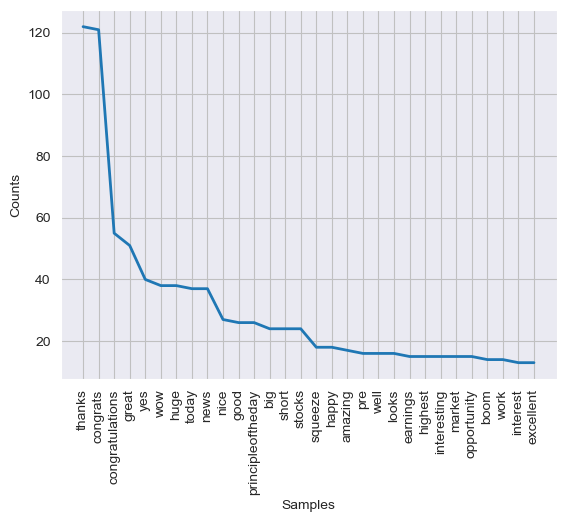

thanks             122
congrats           121
congratulations     55
great               51
yes                 40
                  ... 
yuan                 1
wwoooww              1
garvert              1
sweeet               1
watching             1
Name: text, Length: 1829, dtype: int64


In [216]:
all_words = df_long_term['text'].str.lower().replace(to_replace='(\d)+', value=np.nan,regex=True)
for i in stop :
    all_words = all_words.replace(to_replace=r'\b%s\b'%i, value=np.nan,regex=True)
all_words = all_words.str.lower().str.split(' ').explode().dropna()
print(type(all_words))
counts = all_words.value_counts()
sns.set_style('darkgrid')
nlp_words_long=nltk.FreqDist(all_words)
nlp_words_long.plot(30)
print(counts)

<class 'pandas.core.series.Series'>


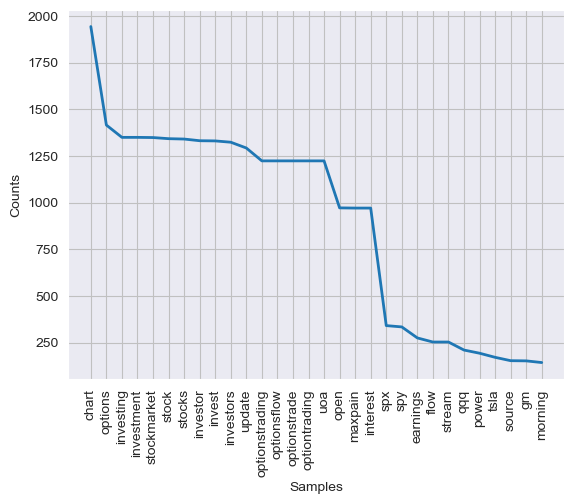

chart          1944
options        1416
investment     1350
investing      1350
stockmarket    1349
               ... 
pr                1
cof               1
gnhay             1
rum               1
february          1
Name: text, Length: 4191, dtype: int64


In [215]:
all_words = df_short_term['text'].str.lower().replace(to_replace='(\d)+', value=np.nan,regex=True)
for i in stop :
    all_words = all_words.replace(to_replace=r'\b%s\b'%i, value=np.nan,regex=True)
all_words = all_words.str.lower().str.split(' ').explode().dropna()
print(type(all_words))
counts = all_words.value_counts()
sns.set_style('darkgrid')
nlp_words_short=nltk.FreqDist(all_words)
nlp_words_short.plot(30)
print(counts)

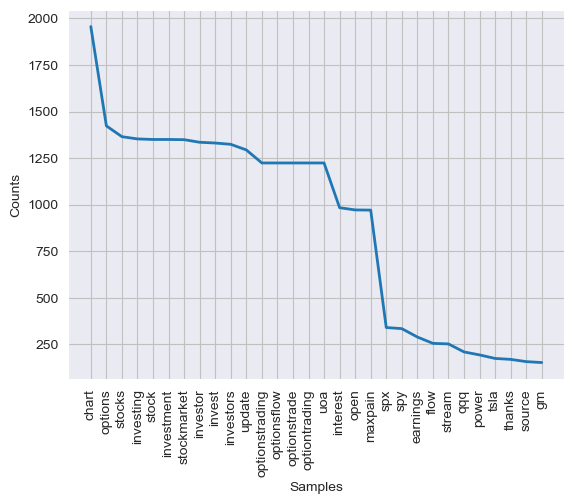

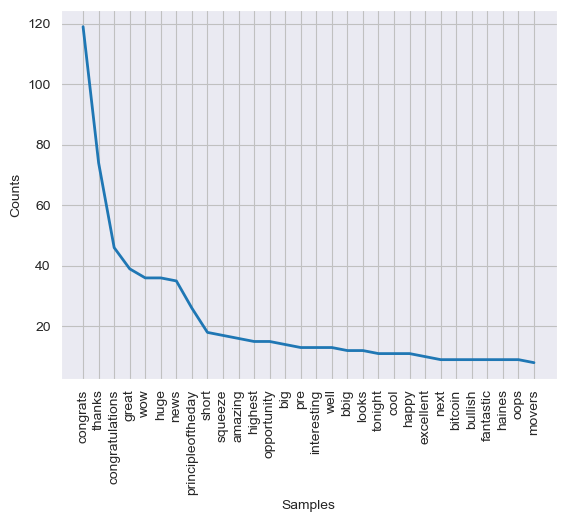

thanks             122
congrats           121
congratulations     55
great               51
yes                 40
                  ... 
yuan                 1
wwoooww              1
garvert              1
sweeet               1
watching             1
Name: text, Length: 1829, dtype: int64


In [228]:
df_short_not_long = nlp_words_short + nlp_words_long
df_long_not_short = nlp_words_long  - nlp_words_short

df_short_not_long.plot(30)
df_long_not_short.plot(30)
print(counts)